<a href="https://colab.research.google.com/github/albertbaezd/data-mining-final-project/blob/develop/Data_Mining_project_code_Albert_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
from google.colab import drive
from sklearn.utils import resample
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


# import the datasets: -  - Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder
# train_data = pd.read_csv("census-income.data.csv") - Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder
# test_data = pd.read_csv("census-income.test.csv")  - Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder



In [22]:
'''
Here, we authenticate with Google Drive to add the datafiles from a Drive folder

Instructions:

1. Create a folder in your Google Drive, called data-mining-csv-files
2. Insert both csv files (test and train) with the original names there.
3. Just run this cell to import the code
'''
from google.colab import drive
drive.mount('/content/drive')

# train_data = pd.read_csv("/content/drive/My Drive/data-mining-csv-files/census-income.data.csv") #- Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder
# test_data = pd.read_csv("/content/drive/My Drive/data-mining-csv-files/census-income.test.csv")  #- Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder
train_data = pd.read_csv("/content/drive/My Drive/data-mining-csv-files/train_data_d.csv") #- Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder
test_data = pd.read_csv("/content/drive/My Drive/data-mining-csv-files/test_data_d.csv")  #- Albert: remove comment if you want to manually place the files here. If not, it's going to use a Google Drive folder

# Displaying results:

print(train_data)
print(test_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       Unnamed: 0   age  work-class    fnlwgt  education_num  marital-status  \
0               0  39.0         6.0   77516.0           13.0             4.0   
1               1  50.0         5.0   83311.0           13.0             2.0   
2               2  38.0         3.0  215646.0            9.0             0.0   
3               3  53.0         3.0  234721.0            7.0             2.0   
4               4  28.0         3.0  338409.0           13.0             2.0   
...           ...   ...         ...       ...            ...             ...   
32556       32556  27.0         3.0  257302.0           12.0             2.0   
32557       32557  40.0         3.0  154374.0            9.0             2.0   
32558       32558  58.0         3.0  151910.0            9.0             6.0   
32559       32559  22.0         3.0  201490.0            9.0           

<ipython-input-25-a472cde6df97>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=train_data, ax=axs[0], palette=train_palette)
<ipython-input-25-a472cde6df97>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=test_data, ax=axs[1], palette=test_palette)


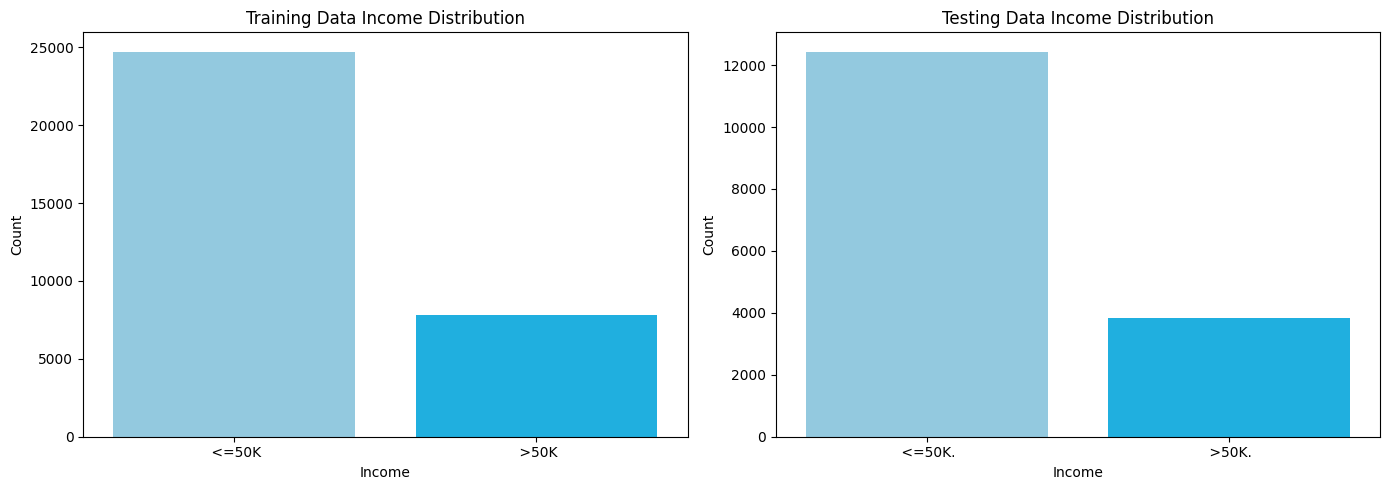

In [ ]:
# Class Distribution: Plot the distribution of the target variable (income)
# to check for class imbalance.

# Set up a subplot grid for training and testing distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Different sky-blue-themed colors
train_palette = ['skyblue', 'deepskyblue']
test_palette = ['skyblue', 'deepskyblue']

# Training data
sns.countplot(x='income', data=train_data, ax=axs[0], palette=train_palette)
axs[0].set_title('Training Data Income Distribution')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Income')

# Testing data
sns.countplot(x='income', data=test_data, ax=axs[1], palette=test_palette)
axs[1].set_title('Testing Data Income Distribution')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Income')

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
'''
V0: just OHE
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer

# Function to train the Random Forest model
def train_random_forest(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    return model

# Evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model without SMOTE
    model = train_random_forest(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy_test, report_test = evaluate_model(model, X_test, y_test)
    print(f'Accuracy (Test Data): {accuracy_test}')
    print(f'Classification Report (Test Data):\n{report_test}')

    # Evaluate the training model to check for overfitting
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy (Training Data): {accuracy_train}')
    print(f'Classification Report (Training Data):\n{report_train}')

if __name__ == '__main__':
    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accuracy (Test Data): 0.8515447454087587
Classificatio

In [ ]:
'''
One Hot Encoding Implementation, Smote # default, version 1
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE


# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data

def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer


# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Train the Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_smote, y_smote)

    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_smote, y_smote)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy test: {accuracy}')
    print(f'Classification Report test:\n{report}')

    # Evaluate the test model
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy train: {accuracy_train}')
    print(f'Classification Report train:\n{report_train}')

if __name__ == '__main__':
    main()

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accuracy test: 0.8487193661323015
Classification Repor

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Categorical features before encoding: []
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: []
Encoded 'income': [0 1]
Accuracy test: 0.8431914501566243
Classification Report test:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12435
           1       0.67      0.67      0.67      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.78      0.78     16281
weighted avg       0.84      0.84      0.84     16281

Accuracy train: 0.9999385768250361
Classification Report train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24720
           1       1.00      1.00      1.00      7841

    accuracy                           1.00     32561
   macro avg       1.00      1.00      1.00     32561
weighted avg       1.00      1.00      1.00     32561

In [ ]:
'''
One Hot Encoding Implementation # removing fnlweight column, version 2
# Version 2

Outcome: less precision
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE


# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data

def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    fnlwgt_column = 'fnlwgt'  # Define the column name to be dropped

    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # Drop the 'fnlwgt' column from the dataset
    if fnlwgt_column in data.columns:
        data = data.drop(columns=[fnlwgt_column])
        print(f"'{fnlwgt_column}' column dropped.")
    else:
        print(f"No '{fnlwgt_column}' column to drop.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer

# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Train the Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_smote, y_smote)

    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_smote, y_smote)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}')

if __name__ == '__main__':
    main()

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
'fnlwgt' column dropped.
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
'fnlwgt' column dropped.
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accu

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
'fnlwgt' column dropped.
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
'fnlwgt' column dropped.
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accuracy: 0.839690436705362
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12435
           1       0.68      0.62      0.65      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.76      0.77     16281
weighted avg       0.84      0.84      0.84     16281


In [ ]:
train_data.columns

Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')

In [ ]:
'''
One Hot Encoding Implementation # default, version 3
Using Label Encoding, Smote
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Function to preprocess data using label encoding
def preprocess_data(data, encoders=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)

    # Initialize or apply existing label encoders
    if encoders is None:
        encoders = {}
        for feature in categorical_features:
            le = LabelEncoder()
            data[feature] = le.fit_transform(data[feature])
            encoders[feature] = le
    else:
        for feature, le in encoders.items():
            data[feature] = le.transform(data[feature])

    print("Encoded features:", categorical_features)  # Debug statement

    # Encode the target variable
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    # All features are now numeric, so return the numeric dataframe directly
    X = data.drop(columns=[income_column]).values

    return X, y, encoders

# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Train the Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_smote, y_smote)

    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data with Label Encoding
    X_train, y_train, encoders = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_smote, y_smote)

    # Preprocess testing data using the same encoders
    X_test, y_test, _ = preprocess_data(test_data, encoders, is_train=False)

    # Evaluate the model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}')

    # Evaluate the model
    accuracy1, report1 = evaluate_model(model, X_train, y_train)
    print(f'Accuracy: {accuracy1}')
    print(f'Classification Report:\n{report1}')

if __name__ == '__main__':
    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Encoded features: []
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Encoded features: []
Encoded 'income': [0 1]
Accuracy: 0.8431914501566243
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12435
           1       0.67      0.67      0.67      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.78   

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Encoded features: []
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Encoded features: []
Encoded 'income': [0 1]
Accuracy: 0.8431914501566243
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12435
           1       0.67      0.67      0.67      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.78      0.78     16281
weighted avg       0.84      0.84      0.84     16281

Accuracy: 0.9999385768250361
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24720
           1       1.00      1.00      1.00      7841

    accuracy                           1.00     32561
   macro avg       1.00      1.00      1.00     32561
weighted avg       1.00      1.00      1.00     32561

In [ ]:
'''
# version 4
Using Label Encoding, Without Smote
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Function to preprocess data using label encoding
def preprocess_data(data, encoders=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)

    # Initialize or apply existing label encoders
    if encoders is None:
        encoders = {}
        for feature in categorical_features:
            le = LabelEncoder()
            data[feature] = le.fit_transform(data[feature])
            encoders[feature] = le
    else:
        for feature, le in encoders.items():
            data[feature] = le.transform(data[feature])

    print("Encoded features:", categorical_features)  # Debug statement

    # Encode the target variable
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    # All features are now numeric, so return the numeric dataframe directly
    X = data.drop(columns=[income_column]).values

    return X, y, encoders

# Function to train the Random Forest model without SMOTE
def train_random_forest(X, y):
    # Train the Random Forest without SMOTE
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data with Label Encoding
    X_train, y_train, encoders = preprocess_data(train_data, is_train=True)

    # Train the Random Forest without SMOTE
    model = train_random_forest(X_train, y_train)

    # Preprocess testing data using the same encoders
    X_test, y_test, _ = preprocess_data(test_data, encoders, is_train=False)

    # Evaluate the model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}')

if __name__ == '__main__':
    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Encoded features: []
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Encoded features: []
Encoded 'income': [0 1]
Accuracy: 0.8534488053559364
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.77   

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Encoded features: []
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Encoded features: []
Encoded 'income': [0 1]
Accuracy: 0.8534488053559364
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281


In [ ]:
'''
 # version 5
Using Label Encoding, Without Smote
Using hyperparameter tuning (gridsearchcv)
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Function to preprocess data using label encoding
def preprocess_data(data, encoders=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)

    # Initialize or apply existing label encoders
    if encoders is None:
        encoders = {}
        for feature in categorical_features:
            le = LabelEncoder()
            data[feature] = le.fit_transform(data[feature])
            encoders[feature] = le
    else:
        for feature, le in encoders.items():
            data[feature] = le.transform(data[feature])

    print("Encoded features:", categorical_features)  # Debug statement

    # Encode the target variable
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    # All features are now numeric, so return the numeric dataframe directly
    X = data.drop(columns=[income_column]).values

    return X, y, encoders

# Function to perform hyperparameter tuning with RandomForestClassifier
def train_random_forest_with_tuning(X, y):
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X, y)

    # Return the best model
    print(f"Best Parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data with Label Encoding
    X_train, y_train, encoders = preprocess_data(train_data, is_train=True)

    # Train the Random Forest with hyperparameter tuning
    model = train_random_forest_with_tuning(X_train, y_train)

    # Preprocess testing data using the same encoders
    X_test, y_test, _ = preprocess_data(test_data, encoders, is_train=False)

    # Evaluate the model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}')

if __name__ == '__main__':
    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Encoded features: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Encoded features: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income

In [13]:
'''
Version 7: no smote, OHE, using parameters
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer

# Function to train the Random Forest model with specified hyperparameters
def train_random_forest(X, y):
    # Initialize the RandomForestClassifier with the desired hyperparameters
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=2,
        bootstrap=True,
        random_state=42
    )
    model.fit(X, y)

    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model using specified hyperparameters
    model = train_random_forest(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the model on the test data
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy (Test Data): {accuracy}')
    print(f'Classification Report (Test Data):\n{report}')

    # Evaluate the model on the training data
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy (Training Data): {accuracy_train}')
    print(f'Classification Report (Training Data):\n{report_train}')

if __name__ == '__main__':
    # Load your datasets (replace with actual file paths)
    # train_data = pd.read_csv('./census-income.data (3).csv')
    # test_data = pd.read_csv('./census-income.test (2).csv')

    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accuracy (Test Data): 0.8579325594250967
Classificatio

In [19]:
'''
V8: smote, OHE, hyperparameters applied
Best hyperparameters as determined in the Hyperparameter Tuning option
Using: ACCURACY focused prediction
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # Convert 'income' to string explicitly to avoid AttributeError
    data[income_column] = data[income_column].astype(str)

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '', regex=False)
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer


# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Define the Random Forest model with specified hyperparameters
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=10,
        bootstrap=False,
        random_state=42
    )

    # Train (fit) the model using the resampled data
    model.fit(X_smote, y_smote)

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE and specified hyperparameters
    model = train_random_forest_with_smote(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy test: {accuracy}')
    print(f'Classification Report test:\n{report}')

    # Evaluate the training model
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy train: {accuracy_train}')
    print(f'Classification Report train:\n{report_train}')

if __name__ == '__main__':
    main()


Initial columns: Index(['Unnamed: 0', 'age', 'work-class', 'fnlwgt', 'education_num',
       'marital-status', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-worked-per-week', 'native-country', 'occupation',
       'income'],
      dtype='object')
Categorical features before encoding: []
Encoded 'income': [0 1]
Initial columns: Index(['Unnamed: 0', 'age', 'work-class', 'fnlwgt', 'education_num',
       'marital-status', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-worked-per-week', 'native-country', 'occupation',
       'income'],
      dtype='object')
Adjusted 'income' for test data: ['0' '1']
Categorical features before encoding: []
Encoded 'income': [0 1]
Accuracy test: 0.8544315459738345
Classification Report test:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     12435
           1       0.70      0.67      0.69      3846

    accuracy                           0.85  

In [20]:
'''
V9: smote, OHE, hyperparameters applied
Best hyperparameters as determined in the Hyperparameter Tuning option
Using: BALANCED focused prediction
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # Convert 'income' to string explicitly to avoid AttributeError
    data[income_column] = data[income_column].astype(str)

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '', regex=False)
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer


# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Define the Random Forest model with specified hyperparameters
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=2,
        bootstrap=False,
        random_state=42
    )

    # Train (fit) the model using the resampled data
    model.fit(X_smote, y_smote)

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE and specified hyperparameters
    model = train_random_forest_with_smote(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy test: {accuracy}')
    print(f'Classification Report test:\n{report}')

    # Evaluate the training model
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy train: {accuracy_train}')
    print(f'Classification Report train:\n{report_train}')

if __name__ == '__main__':
    main()


Initial columns: Index(['Unnamed: 0', 'age', 'work-class', 'fnlwgt', 'education_num',
       'marital-status', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-worked-per-week', 'native-country', 'occupation',
       'income'],
      dtype='object')
Categorical features before encoding: []
Encoded 'income': [0 1]
Initial columns: Index(['Unnamed: 0', 'age', 'work-class', 'fnlwgt', 'education_num',
       'marital-status', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-worked-per-week', 'native-country', 'occupation',
       'income'],
      dtype='object')
Adjusted 'income' for test data: ['0' '1']
Categorical features before encoding: []
Encoded 'income': [0 1]
Accuracy test: 0.8414102327866838
Classification Report test:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     12435
           1       0.65      0.72      0.68      3846

    accuracy                           0.84  

Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Encoded features: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Encoded features: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accuracy: 0.864443216018672
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     12435
           1       0.77      0.61      0.68      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.78      0.80     16281
weighted avg       0.86      0.86      0.86     16281



Initial columns: Index(['Unnamed: 0', 'age', 'work-class', 'fnlwgt', 'education_num',
       'marital-status', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-worked-per-week', 'native-country', 'occupation',
       'income'],
      dtype='object')
Categorical features before encoding: []
Encoded 'income': [0 1]
Initial columns: Index(['Unnamed: 0', 'age', 'work-class', 'fnlwgt', 'education_num',
       'marital-status', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-worked-per-week', 'native-country', 'occupation',
       'income'],
      dtype='object')
Adjusted 'income' for test data: ['0' '1']
Categorical features before encoding: []
Encoded 'income': [0 1]
Accuracy test: 0.8414102327866838
Classification Report test:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     12435
           1       0.65      0.72      0.68      3846

    accuracy                           0.84  

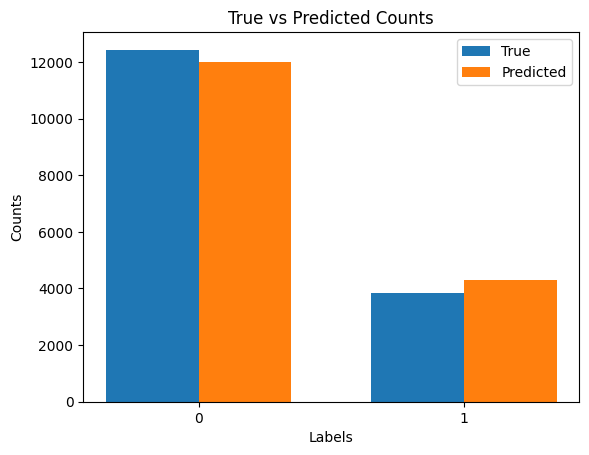

In [23]:
'''
V10: smote, OHE, hyperparameters applied
Best hyperparameters as determined in the Hyperparameter Tuning option
Using: BALANCED focused prediction
Plotting results
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # Convert 'income' to string explicitly to avoid AttributeError
    data[income_column] = data[income_column].astype(str)

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '', regex=False)
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer


# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Define the Random Forest model with specified hyperparameters
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=2,
        bootstrap=False,
        random_state=42
    )

    # Train (fit) the model using the resampled data
    model.fit(X_smote, y_smote)

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Function to plot bar chart of predictions
def plot_predictions(y_true, y_pred):
    unique_labels = np.unique(y_true)
    true_counts = [np.sum(y_true == label) for label in unique_labels]
    pred_counts = [np.sum(y_pred == label) for label in unique_labels]

    fig, ax = plt.subplots()
    width = 0.35
    ind = np.arange(len(unique_labels))
    ax.bar(ind, true_counts, width, label='True')
    ax.bar(ind + width, pred_counts, width, label='Predicted')

    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_title('True vs Predicted Counts')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(unique_labels)
    ax.legend()

    plt.show()

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE and specified hyperparameters
    model = train_random_forest_with_smote(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy test: {accuracy}')
    print(f'Classification Report test:\n{report}')

    # Evaluate the training model
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy train: {accuracy_train}')
    print(f'Classification Report train:\n{report_train}')

    # Plot predictions
    y_pred_test = model.predict(X_test)
    plot_predictions(y_test, y_pred_test)

if __name__ == '__main__':
    main()

In [ ]:
'''
Random Forest implementation
'''

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1 - declaring x and y values for random forests

x_train_rf = train_data.drop('income', axis=1)  # Features
y_train_rf = train_data['income']               # Target variable

x_test_rf = test_data.drop('income', axis=1)  # Features
y_test_rf = test_data['income']               # Target variable

# Step 2:
# Perform one-hot encoding if there are categorical variables
# Example:

'''
OHE = One Hot Encoding. It's required to run the Random Forest Classifier from SKLEARN
'''

x_train_rf_ohe = pd.get_dummies(x_train_rf)
x_test_rf_ohe = pd.get_dummies(x_test_rf)

# Step 3: Instantiate the Random Forest Classifier
# You can specify hyperparameters such as n_estimators, max_depth, etc.
# Example:
# rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier_train = RandomForestClassifier(random_state=42)
rf_classifier_test = RandomForestClassifier(random_state=42)

# Step 4: Train the models
rf_classifier_train.fit(x_train_rf_ohe, y_train_rf)
rf_classifier_test.fit(x_test_rf_ohe, y_test_rf)

# Step 5: Making predictions - Assuming 'new_data' is the new DataFrame
# we want to check containing features (excluding the income column)

# x_train_rf = train_data.drop('income', axis=1)  # Features
# y_train_rf = train_data['income']               # Target variable
predictions_train_rf = rf_classifier_train.predict(x_train_rf_ohe)

predictions_test_rf = rf_classifier_test.predict(x_test_rf_ohe)

print("Predictions in training \n")
print(predictions_train_rf)

print("Predictions in TESTING \n")
print(predictions_test_rf)



Predictions in training 

[' <=50K' ' <=50K' ' <=50K' ... ' <=50K' ' <=50K' ' >50K']
Predictions in TESTING 

[' <=50K.' ' <=50K.' ' >50K.' ... ' <=50K.' ' <=50K.' ' >50K.']


In [8]:
# V9

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer

# Function to train the best Random Forest model using Grid Search and SMOTE
def train_best_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Initialize the Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)

    # Apply Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_smote, y_smote)

    print(f'Best Hyperparameters: {grid_search.best_params_}')
    print(f'Best Training Accuracy: {grid_search.best_score_}')

    # Return the best model found by Grid Search
    return grid_search.best_estimator_

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train the best model using Grid Search and SMOTE
    best_model = train_best_random_forest_with_smote(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy, report = evaluate_model(best_model, X_test, y_test)
    print(f'Accuracy test: {accuracy}')
    print(f'Classification Report test:\n{report}')

    # Evaluate the training model
    accuracy_train, report_train = evaluate_model(best_model, X_train, y_train)
    print(f'Accuracy train: {accuracy_train}')
    print(f'Classification Report train:\n{report_train}')

if __name__ == '__main__':
    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Assuming train_data and test_data are already loaded as dataframes
# train_data, test_data

# Function to preprocess data
def preprocess_data(data, transformer=None, is_train=True):
    print("Initial columns:", data.columns)  # Initial check of all columns in the dataset

    income_column = 'income'
    if income_column not in data.columns:
        raise ValueError(f"The column '{income_column}' does not exist in the dataset.")

    # If it's test data, handle the period at the end
    if not is_train:
        data[income_column] = data[income_column].str.strip().str.replace('.', '')
        print("Adjusted 'income' for test data:", data[income_column].unique())  # Debug

    # Identify and store categorical features excluding 'income'
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    if income_column in categorical_features:
        categorical_features.remove(income_column)
    print("Categorical features before encoding:", categorical_features)  # Debug statement

    # Apply ColumnTransformer only to categorical features excluding 'income'
    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough')
        X = transformer.fit_transform(data.drop(columns=[income_column]))
    else:
        X = transformer.transform(data.drop(columns=[income_column]))

    # Now encode the 'income' column after categorical handling
    y = LabelEncoder().fit_transform(data[income_column])
    print("Encoded 'income':", np.unique(y))  # Debug the output of the encoded income

    return X, y, transformer

# Function to train the Random Forest model with SMOTE
def train_random_forest_with_smote(X, y):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    # Train the Random Forest model using default hyperparameters
    model = RandomForestClassifier(random_state=42)
    model.fit(X_smote, y_smote)

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Main execution function
def main():
    # Preprocess training data
    X_train, y_train, transformer = preprocess_data(train_data, is_train=True)

    # Train model with SMOTE using default hyperparameters
    model = train_random_forest_with_smote(X_train, y_train)

    # Preprocess testing data using the same transformer
    X_test, y_test, _ = preprocess_data(test_data, transformer, is_train=False)

    # Evaluate the test model
    accuracy, report = evaluate_model(model, X_test, y_test)
    print(f'Accuracy test: {accuracy}')
    print(f'Classification Report test:\n{report}')

    # Evaluate the training model
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print(f'Accuracy train: {accuracy_train}')
    print(f'Classification Report train:\n{report_train}')

if __name__ == '__main__':
    main()


Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Initial columns: Index(['age', 'work-class', 'fnlwgt', 'education', 'education_num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-worked-per-week',
       'native-country', 'income'],
      dtype='object')
Adjusted 'income' for test data: ['<=50K' '>50K']
Categorical features before encoding: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Encoded 'income': [0 1]
Accuracy test: 0.8487193661323015
Classification Repor

In [ ]:
'''
Confusion matrix for Random Forests
'''

from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test_rf, predictions_test_rf)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test_rf, predictions_test_rf)

print("Confusion Matrix:")
print(conf_matrix_rf)
print("Accuracy:", accuracy_rf)


Confusion Matrix:
[[12435     0]
 [    1  3845]]
Accuracy: 0.9999385787113814


In [ ]:
'''
Code block to replace missing values with mode
'''

# This function takes a dataframe and returns * A MODIFIED COPY *. Doesn't change the original
def replace_question_marks(df, columns_to_replace):
    most_common_elements = {}
    most_common_counts = {}
    df_copy = df.copy()  # Create a copy of the original DataFrame

    for col in columns_to_replace:
        # Find the most common element and its count in the column
        value_counts = df[col].value_counts()
        most_common = value_counts.idxmax()
        most_common_count = value_counts.max()

        most_common_elements[col] = most_common
        most_common_counts[col] = most_common_count

        # Replace ' ?' with the most common element in the column
        df_copy[col] = df_copy[col].replace(' ?', most_common)

    return df_copy, most_common_elements, most_common_counts

columns_to_replace = ['work-class', 'occupation', 'native-country']



In [ ]:
'''
Testing without missing values
'''
data_train_modified_rf, most_common_elements_data_train_rf, most_common_counts_data_train_rf = replace_question_marks(train_data, columns_to_replace)
data_test_modified_rf, most_common_elements_data_test_rf, most_common_counts_data_test_rf = replace_question_marks(test_data, columns_to_replace)

# Step 1 - declaring x and y values for random forests

x_train_rf_modified = data_train_modified_rf.drop('income', axis=1)  # Features
y_train_rf_modified = data_train_modified_rf['income']               # Target variable

x_test_rf_modified = data_test_modified_rf.drop('income', axis=1)  # Features
y_test_rf_modified = data_test_modified_rf['income']               # Target variable

# Step 2:
# Perform one-hot encoding if there are categorical variables
# Example:

'''
OHE = One Hot Encoding. It's required to run the Random Forest Classifier from SKLEARN
'''

x_train_rf_ohe_modified = pd.get_dummies(x_train_rf_modified)
x_test_rf_ohe_modified = pd.get_dummies(x_test_rf_modified)

# Step 3: Instantiate the Random Forest Classifier
# You can specify hyperparameters such as n_estimators, max_depth, etc.
# Example:
# rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier_train1 = RandomForestClassifier(random_state=42)
rf_classifier_test1 = RandomForestClassifier(random_state=42)

# Step 4: Train the models
rf_classifier_train1.fit(x_train_rf_ohe_modified, y_train_rf_modified)
rf_classifier_test1.fit(x_test_rf_ohe_modified, y_test_rf_modified)

# Step 5: Making predictions - Assuming 'new_data' is the new DataFrame
# we want to check containing features (excluding the income column)

# x_train_rf = train_data.drop('income', axis=1)  # Features
# y_train_rf = train_data['income']               # Target variable
predictions_train_rf1 = rf_classifier_train1.predict(x_train_rf_ohe_modified)

predictions_test_rf1 = rf_classifier_test1.predict(x_test_rf_ohe_modified)

print("Predictions in training \n")
print(predictions_train_rf1)

print("Predictions in TESTING \n")
print(predictions_test_rf1)



Predictions in training 

[' <=50K' ' <=50K' ' <=50K' ... ' <=50K' ' <=50K' ' >50K']
Predictions in TESTING 

[' <=50K.' ' <=50K.' ' >50K.' ... ' <=50K.' ' <=50K.' ' >50K.']


In [ ]:
'''
Confusion matrix for Random Forests # Without missing
'''

from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate confusion matrix
conf_matrix_rf1 = confusion_matrix(y_test_rf_modified, predictions_test_rf1)

# Calculate accuracy
accuracy_rf1 = accuracy_score(y_test_rf_modified, predictions_test_rf1)

print("Confusion Matrix new:")
print(conf_matrix_rf1)
print("Accuracy new:", accuracy_rf1)


Confusion Matrix new:
[[12435     0]
 [    1  3845]]
Accuracy new: 0.9999385787113814
